### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import PIL.Image as imgg
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt

### 1.  ViT: Transformers for image recognition at scale

<ins>Reference</ins>: Dosovitskiy, Alexey, Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Thomas Unterthiner, Mostafa Dehghani et al. "An image is worth 16x16 words: Transformers for image recognition at scale." arXiv preprint arXiv:2010.11929 (2020).

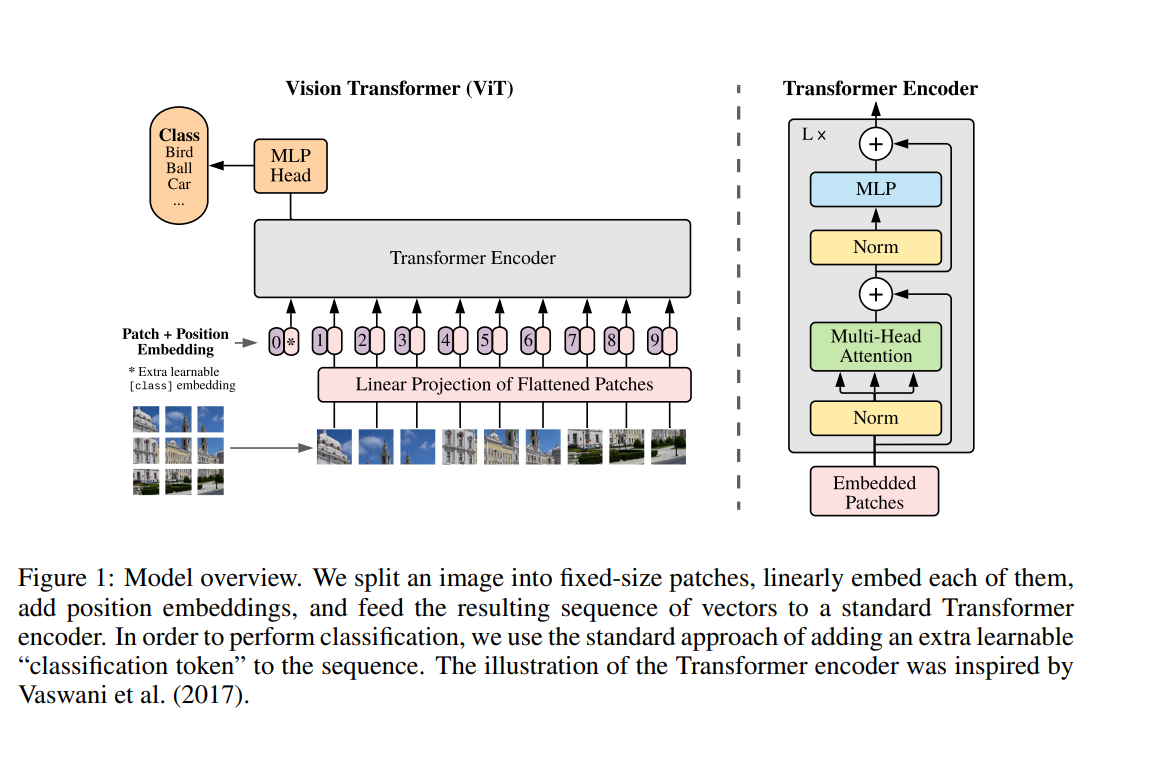

In [2]:
Image(filename="imgs/vit.png")

### 2. Linear Projection and Flattented Patches

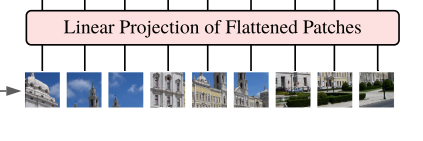

In [3]:
Image(filename="imgs/linear_proj_flatten.png")

In [4]:
class PatchEmbedding(nn.Module):
    """Split image into patches and then embedd them.
    
        Attributes
            -------------------------------------------
            n_patches : int
                Number of patches inside of our image.

            proj : nn.Conv2d
                Convolutional layer that does both the splitting into patches, and their embedding."""

    def __init__(self, img_size, patch_size, in_chans = 3, embed_dim = 768):
        """
        params:
        -------------------------------------------
            img_size: int
                Size of the image (it is a square), but can be modified.

            patch_size : int
                Size of the patch (it is a square), can be modified.

            in_chans : int
                Number of input channels. By default it is 3 (RGB), a hyperparameter.

            embed_dim : int
                The emmbedding dimension.

    """
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        """
        params:
        -------------------------------------------
        x : torch.Tensor
        Shape : (n_samples, in_chans, img_size, img_size).

        returns:
        -------------------------------------------
        x : torch.Tensor
        Shape : (n_samples, n_patches, embed_dim).
        
        """
        x = self.proj(x)  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)
        return x
    
    

### 3. Attention Module

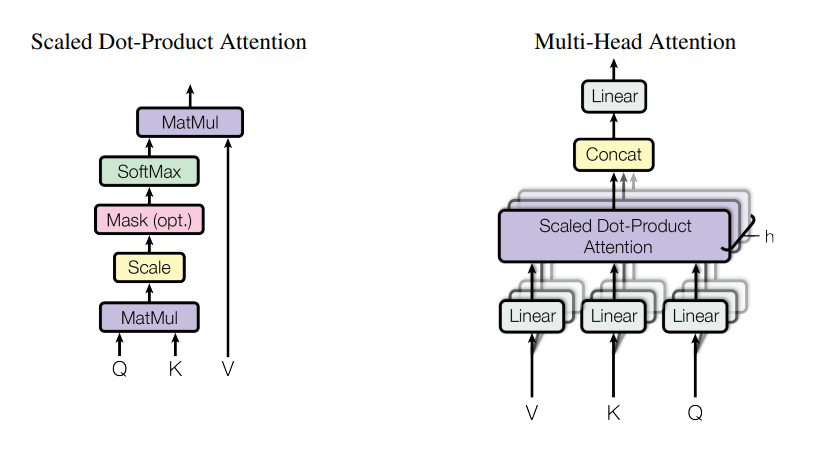

In [5]:
Image(filename="imgs/scaled_dot_product_attention.png")

In [6]:
class Attention(nn.Module):
    """Attention mechanism.

        Attributes
        -------------------------------------------
            scale : float
                Normalizing constant for the dot product.

            qkv : nn.Linear
                Linear projection for the query, key and value.

            proj : nn.Linear
                Linear mapping that takes in the concatenated output of all attention heads and maps it into a new space.

            attn_drop, proj_drop : nn.Dropout
                Dropout layers.

    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        """
            Parameters
            -------------------------------------------
                dim : int
                    The input and out dimension of per token features.

                n_heads : int
                    Number of attention heads.

                qkv_bias : bool
                    If True then we include bias to the query, key and value projections.

                attn_p : float
                    Dropout probability applied to the query, key and value tensors.

                proj_p : float
                    Dropout probability applied to the output tensor."""
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim//n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """params:     
        -------------------------------------------
            x : torch.Tensor
            Shape: (n_samples, n_patches + 1, dim). +1 for the extra learnable [class] embedding.

        returns:
        -------------------------------------------
            x: torch.Tensor
            Shape: (n_samples, n_patches + 1, dim). +1 for the extra learnable [class] embedding."""
        
        n_samples, n_tokens, dim = x.shape

        # Sanity check
        if dim != self.dim:
            raise ValueError
        
        #(n_samples, n_patches + 1, 3 * dim)
        qkv = self.qkv(x)  
        
        #(n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)
        
        #(3, n_samples, n_heads, n_patches + 1, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  

        q, k, v = qkv[0], qkv[1], qkv[2]
        
        #(n_samples, n_heads, head_dim, n_patches + 1)
        k_t = k.transpose(-2, -1)  
        
        # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        dp = (q @ k_t)*self.scale 
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)
        
        # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = attn @ v  
        
        # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.transpose(1, 2)  
        
        # (n_samples, n_patches + 1, dim)
        weighted_avg = weighted_avg.flatten(2)  
        
        # (n_samples, n_patches + 1, dim)
        x = self.proj(weighted_avg)  
        
        # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  

        return x


### 4. Multi Layer Perceptron

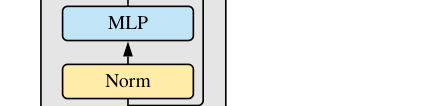

In [7]:
Image(filename="imgs/mlp.png")

In [8]:
class MLP(nn.Module):
    """Multilayer perceptron inside the Transformer Encoder.

        Attributes
        -------------------------------------------
            fc : nn.Linear
                The First linear layer.

            act : nn.GELU
                GELU activation function.

            fc2 : nn.Linear
                The second linear layer.

            drop : nn.Dropout
                Dropout layer."""
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        """
        params:
        -------------------------------------------
            in_features : int
                Number of input features.

            hidden_features : int
                Number of nodes in the hidden layer.

            out_features : int
                Number of output features.

            p : float
                Dropout probability."""
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """
        params:
        -------------------------------------------
            x : torch.Tensor
            Shape: (n_samples, n_patches + 1, in_features).

        returns
        -------------------------------------------
            x : torch.Tensor
            Shape (n_samples, n_patches +1, out_features)
        """
        x = self.fc1(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x

### 5. Transformer Block.

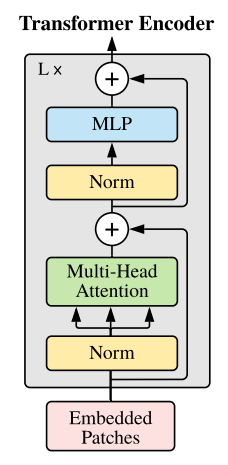

In [9]:
Image(filename="imgs/block.png")

In [10]:
class Block(nn.Module):
    """Transformer block.

        Attributes
        -------------------------------------------
        norm1, norm2 : LayerNorm
            Layer normalization.

        attn : Attention
            Attention module.

        mlp : MLP
            MLP module."""
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        """
        params:
        -------------------------------------------
            dim : int
                Embedding dimension.

            n_heads : int
                Number of attention heads.

            mlp_ratio : float
                Determines the hidden dimension size of the MLP module with respect to dim.

            qkv_bias : bool
                If True then we include bias to the query, key and value projections.

            p, attn_p : float
                Dropout probability."""
        
        
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, attn_p=attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim)

    def forward(self, x):
        """
        params:
        -------------------------------------------
        x : torch.Tensor
        shape: (n_samples, n_patches + 1, dim).

        returns:
        -------------------------------------------
        torch.Tensor
        shape: (n_samples, n_patches + 1, dim)."""
        out_norm = self.norm1(x)
        out_attn = self.attn(out_norm)
        x = x + out_attn

        out_norm = self.norm2(x)
        out_mlp = self.mlp(out_norm)
        x = x + out_mlp

        return x

### Vision Transformer Block and putting it all together

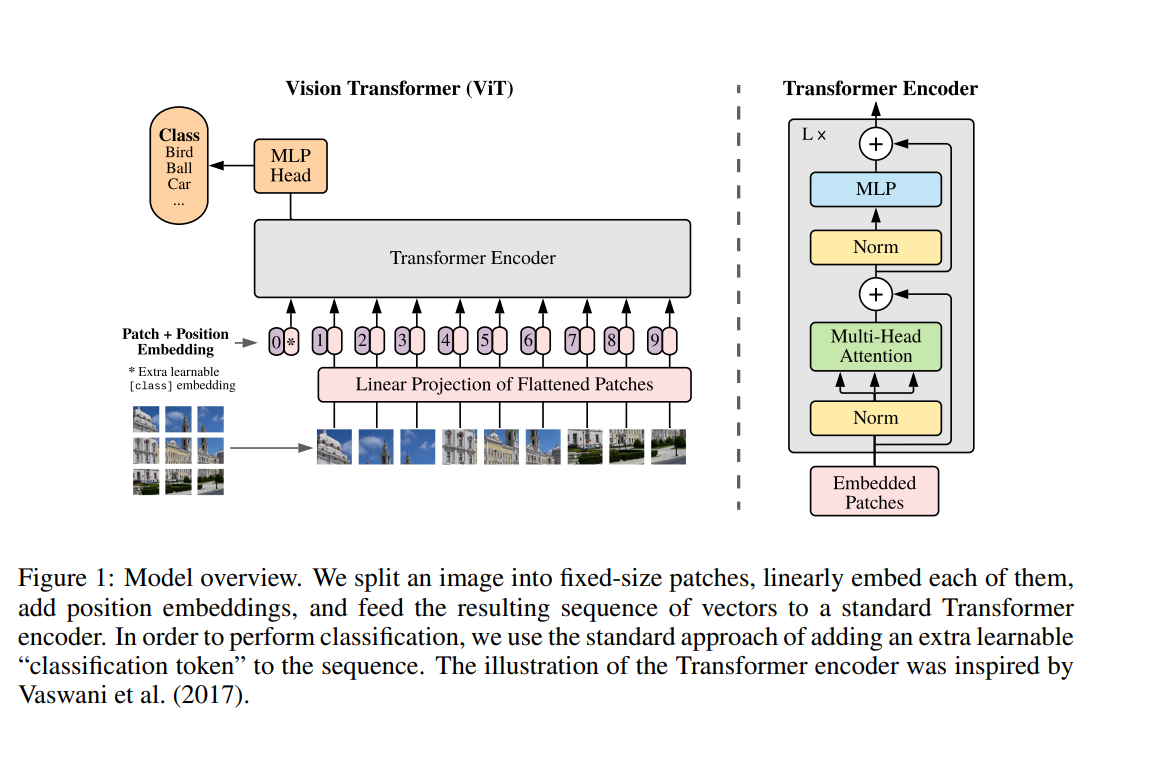

In [11]:
Image(filename="imgs/vit.png")

In [12]:
class VisionTransformer(nn.Module):
    """
    Simplified implementation of the Vision transformer.

    Attributes
    -------------------------------------------
        patch_embed : PatchEmbed
            Instance of PatchEmbed layer.

        cls_token : nn.Parameter
            Learnable parameter that will represent the first token in the sequence. It has `embed_dim` elements. In Fig, it is the extra learnable [class] embedding.

        pos_emb : nn.Parameter
            Positional embedding of the cls token + all the patches.
            It has `(n_patches + 1) * embed_dim` elements.

        pos_drop : nn.Dropout
            Dropout layer.

        blocks : nn.ModuleList
            List of `Block` modules.

        norm : nn.LayerNorm
            Layer normalization."""

    def __init__(self, img_size=384, patch_size=16, in_chans=3, n_classes=1000, embed_dim=768, depth=12, n_heads=12, mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.,):
        """
        params:
        -------------------------------------------
            img_size : int
                Both height and the width of the image (it is a square).

            patch_size : int
                Both height and the width of the patch (it is a square).

            in_chans : int
                Number of input channels.

            n_classes : int
                Number of classes.

            embed_dim : int
                Dimensionality of the token/patch embeddings.

            depth : int
                Number of Transformer blocks.

            n_heads : int
                Number of attention heads.

            mlp_ratio : float
                Determines the hidden dimension of the `MLP` module.

            qkv_bias : bool
                If True then we include bias to the query, key and value projections.

            p, attn_p : float
                Dropout probability.
        
        """
        
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Total number of tokens = 1 + n_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim,
                n_heads=n_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                p=p,
                attn_p=attn_p,
            )
            for _ in range(depth)
            ])

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)


    def forward(self, x):
        """
        params:
        -------------------------------------------
        x : torch.Tensor
        shape:  (n_samples, in_chans, img_size, img_size).

        returns:
        -------------------------------------------
        logits : torch.Tensor; Logits over all the classes - 
        shape: (n_samples, n_classes).
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(n_samples, -1, -1)  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)

        # Added positional embedding of the cls token + all the patches to indicate the positions. 
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x) # (n_samples, 1 + n_patches, embed_dim) (probability of dropping)
        
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        cls_token_final = x[:, 0]  # just the CLS token
        x = self.head(cls_token_final)

        return x, cls_token_final


### Main 

In [13]:
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
print_every = 500 # 2000 minibatches
epochs = 5

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [15]:
custom_config = {
        "img_size": 32,
        "in_chans": 3,
        "patch_size": 16,
        "embed_dim": 1024,
        "depth": 24,
        "n_heads": 16,
        "qkv_bias": True,
        "mlp_ratio": 4,
}

net = VisionTransformer(**custom_config).to(device)

### Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [17]:
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs, embeddings = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % print_every == print_every - 1:
            print("Epoch: {}, Mini-Batch: {}, loss: {}".format(epoch + 1, i + 1, np.round(running_loss / print_every, 3)))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 2.041
[1,  1000] loss: 1.822
[1,  1500] loss: 1.719
[2,   500] loss: 1.643
[2,  1000] loss: 1.629
[2,  1500] loss: 1.588
[3,   500] loss: 1.499
[3,  1000] loss: 1.491
[3,  1500] loss: 1.482
[4,   500] loss: 1.384
[4,  1000] loss: 1.387
[4,  1500] loss: 1.391
[5,   500] loss: 1.288
[5,  1000] loss: 1.288
[5,  1500] loss: 1.276
Finished Training


Let’s quickly save our trained model:

In [18]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the transformers outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

In [19]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

GroundTruth:  cat   ship  ship  plane


Okay, now let us see what the neural network thinks these examples above are:

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [20]:
outputs, embeddings = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  plane car   plane deer 


Let us look at how the network performs on the whole dataset.

In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs, embeddings = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 48 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [22]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs, embeddings = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 54.4 %
Accuracy for class: car   is 62.5 %
Accuracy for class: bird  is 19.0 %
Accuracy for class: cat   is 1.5 %
Accuracy for class: deer  is 60.2 %
Accuracy for class: dog   is 41.8 %
Accuracy for class: frog  is 72.3 %
Accuracy for class: horse is 61.2 %
Accuracy for class: ship  is 67.2 %
Accuracy for class: truck is 44.6 %
